In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") 

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

d:\agenticBatch\venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
llm.invoke("Hello, How are you my friend?")

AIMessage(content="Hello! I'm here to assist you with any questions or concerns you may have. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 15, 'total_tokens': 39, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C9roBsn94JDL075Upybj1u8r0QgJH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--db234bac-dd62-43ae-918a-88dc23b26d0c-0', usage_metadata={'input_tokens': 15, 'output_tokens': 24, 'total_tokens': 39, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [4]:
# Creating Embedding
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(
    model = "text-embedding-3-large"
)

In [5]:
url= "https://lilianweng.github.io/posts/2023-06-23-agent/"

In [6]:
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(url).load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [7]:
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [8]:
docs = [WebBaseLoader(url).load() for url in urls]

In [9]:
#This line flattens a list of lists (docs) into one single list (docs_list).
docs_list = [item for sublist in docs for item in sublist]

In [10]:
#Tiktoken library is from Open AI
from langchain_text_splitters import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100,chunk_overlap=25)

In [11]:
splitted_doc=splitter.split_documents(docs_list)

In [13]:
splitted_doc

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [12]:
from langchain_community.vectorstores import Chroma


In [13]:
vectorStore=Chroma.from_documents(
    documents=splitted_doc,
    collection_name="rag_chroma",
    embedding=embeddings
)

In [14]:
retriever=vectorStore.as_retriever()

In [15]:
retriever.invoke("What is prompt Engineering?")

[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'language': 'en', 'title': "Prompt Engineering | Lil'Log"}, page_content='Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the mode

In [16]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool=create_retriever_tool(
    retriever,
    "retriever_blog_post",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
)

In [17]:
tools = [retriever_tool]

In [18]:
from langgraph.prebuilt import ToolNode
returver_node = ToolNode(tools)

In [19]:
from typing import Annotated,Sequence,TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [20]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

In [21]:
from langchain_core.prompts import PromptTemplate

In [22]:
llm_with_tools=llm.bind_tools(tools)

In [23]:
def LLM_Decision_Maker(state:AgentState):
    print("===>>LLM DECISION MAKER<<===")
    last_message = state["messages"][-1]
    question = last_message.content
    response = llm_with_tools.invoke(question)
    return {"messages":[response]}

In [24]:
from langchain_core.pydantic_v1 import BaseModel,Field

d:\agenticBatch\venv\Lib\site-packages\IPython\core\interactiveshell.py:3667: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score either yes or no")

In [26]:
from typing import Literal
#we use it for type of hinting

In [27]:
def grade_documents1(state:AgentState)->Literal["OutputGeneratorNode","QueryRewriterNode"]:
    print("------->>CALLING GRADE FOR CHECKING RELEVANCY")
    llm_with_structure_op=llm.with_structured_output(grade)
    prompt= PromptTemplate(
        template="""You are a grader deciding assistant and decide if a document is relevant to a user's question.
        Here is the document: {context}
        Here is the user's question: {question}
        If the document talks about or contains information related to the user's question,mark it as relevant.Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
        input_variables=["context","question"]
        )
    chain = prompt | llm_with_structure_op

    message = state['messages']
    last_message = message[-1]
    question = message[0].content
    docs= last_message.content
    scored_result = chain.invoke({"question":question,"context":docs})
    score = scored_result.binary_score
    if score == "yes":
        print("==DOCS ARE RELEVANT==")
        return "Generator"
    else:
        print("==DOCS ARE NOT RELEVANT==")
        return "QueryRewriter"

In [28]:
from langchain import hub
hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [29]:
def generate(state:AgentState):
    print("===RAG OUTPUT GENERATE===")
    message=state["messages"]
    question=message[0].content

    last_message = message[-1]
    docs = last_message.content

    prompt=hub.pull("rlm/rag-prompt")

    rag_chain=prompt | llm
    
    response=rag_chain.invoke({"context": docs, "question": question})
    
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [30]:
from langchain_core.messages import HumanMessage
def rewrite(state:AgentState):
    print("===TRANSFORM QUERY===")
    question=state["messages"][0].content
    
    input= [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response=llm.invoke(input)
    
    return {"messages": [response]}

In [31]:
from langgraph.graph import END, StateGraph, START

In [32]:
workflow = StateGraph(AgentState)
workflow.add_node("LLMDecision",LLM_Decision_Maker)
workflow.add_node("VectorRetrieverNode1",returver_node)
workflow.add_node("QueryRewriterNode",rewrite)
workflow.add_node("OutputGeneratorNode",generate)
workflow.add_edge(START,"LLMDecision")
workflow.add_edge("QueryRewriterNode","LLMDecision")

In [33]:
from langgraph.prebuilt import tools_condition


In [34]:
workflow.add_conditional_edges("LLMDecision",tools_condition,{"tools":"VectorRetrieverNode1",END:END})


In [35]:
workflow.add_conditional_edges("VectorRetrieverNode1",grade_documents1,{"Generator":"OutputGeneratorNode","QueryRewriter":"QueryRewriterNode"})

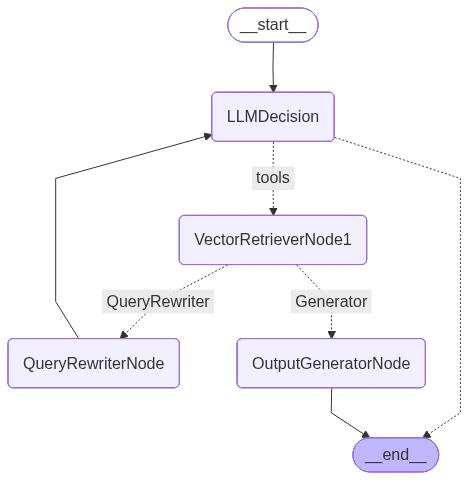

In [36]:
app=workflow.compile()
app

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
app.invoke({"messages":["what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?"]})

===>>LLM DECISION MAKER<<===
------->>CALLING GRADE FOR CHECKING RELEVANCY
==DOCS ARE RELEVANT==
===RAG OUTPUT GENERATE===
this is my response:content='LLM Powered Autonomous Agents use Prompt Engineering to guide the behavior of language models without updating weights. It is an empirical science that requires experimentation and heuristics to determine the best methods. Prompt Engineering helps to steer LLMs towards desired outcomes using language prompts.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 270, 'total_tokens': 322, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C9s4Ti8OaxsrGJ7pDkXeNwux6aP7U', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--

{'messages': [HumanMessage(content='what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='5dba19f5-3a54-48bf-bf21-92decb30c00a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZPg1ErVqROYec0jH8oKVh9rP', 'function': {'arguments': '{"query": "LLM Powered Autonomous Agents"}', 'name': 'retriever_blog_post'}, 'type': 'function'}, {'id': 'call_emLVQyHbdiWXF9U6wVFwsbVa', 'function': {'arguments': '{"query": "planning and reflection in LLM"}', 'name': 'retriever_blog_post'}, 'type': 'function'}, {'id': 'call_mYSwuYYj5LyQe1xVjQCGRNnL', 'function': {'arguments': '{"query": "prompt engineering in LLM"}', 'name': 'retriever_blog_post'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 163, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 

In [39]:
app.invoke({"messages":["hi how are you gpt?"]})

===>>LLM DECISION MAKER<<===


{'messages': [HumanMessage(content='hi how are you gpt?', additional_kwargs={}, response_metadata={}, id='f1aecac5-8cde-4485-b2a5-cda110e4ce11'),
  AIMessage(content="Hello! I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 145, 'total_tokens': 164, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C9s5EIe4gCpUfQYSCadIgep6i6LjL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f1085704-dafa-464c-8401-4128ad02a32f-0', usage_metadata={'input_tokens': 145, 'output_tokens': 19, 'total_tokens': 164, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}

In [40]:
app.invoke({"messages":["what is a capital of india?"]})

===>>LLM DECISION MAKER<<===


{'messages': [HumanMessage(content='what is a capital of india?', additional_kwargs={}, response_metadata={}, id='e15e1c3d-051b-42ab-b20e-131897aebeea'),
  AIMessage(content='The capital of India is New Delhi.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 145, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C9s5Ymm1XoZfntS9dV92VUvOHnRjl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0baca271-3402-483f-ae8e-d5b43f277e2b-0', usage_metadata={'input_tokens': 145, 'output_tokens': 9, 'total_tokens': 154, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [41]:
question="can you explain me what is a task decomposition and why Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks?"

In [42]:
app.invoke({"messages":[question]})

===>>LLM DECISION MAKER<<===


{'messages': [HumanMessage(content='can you explain me what is a task decomposition and why Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks?', additional_kwargs={}, response_metadata={}, id='abd82d67-41ee-4137-8a13-205319cea945'),
  AIMessage(content='Task decomposition is a technique used in machine learning to break down a complex task into smaller, more manageable sub-tasks. By decomposing a complex task, it becomes easier for machine learning models to learn and perform well on the overall task.\n\nChain of Thought (CoT) is a prompting technique introduced by Wei et al. in 2022. CoT has become a standard prompting technique for enhancing model performance on complex tasks due to its effectiveness in leveraging task decomposition. CoT structures the prompt in a way that guides the model through a chain of reasoning steps, where each step builds upon the previous one. This sequential reasoning approach

In [ ]:
text = "Who won the 2022 FIFA World Cup final?"
app.invoke({"messages":[text]})

===>>LLM DECISION MAKER<<===


{'messages': [HumanMessage(content='Who won the 2022 FIFA World Cup final?', additional_kwargs={}, response_metadata={}, id='cc3b9aa0-54a3-41b7-93ad-bf24146b5442'),
  AIMessage(content="I don't have real-time information. You may want to check the latest news or sports websites for the most up-to-date information on the 2022 FIFA World Cup final winner.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 149, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C9s8Safmf4kIkteJwIBT8JE4xNqsV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dab11985-0381-4a97-aa75-a279904b96c1-0', usage_metadata={'input_tokens': 149, 'output_tokens': 38, 'tota

In [44]:
text = "How do agents work in a video game?"
app.invoke({"messages":[text]})

===>>LLM DECISION MAKER<<===


{'messages': [HumanMessage(content='How do agents work in a video game?', additional_kwargs={}, response_metadata={}, id='b77bd368-bfc8-4f19-9479-e41ed6c62d2a'),
  AIMessage(content="In video games, agents refer to entities within the game that are controlled by AI algorithms to interact with the game environment. These agents can take various forms, such as non-player characters (NPCs), enemies, allies, or even the player's own character in single-player games.\n\nThe behavior of agents in a video game is determined by their programmed AI, which governs their decision-making processes, movements, interactions with other entities, and responses to stimuli in the game environment. The complexity of agent behavior can vary widely, depending on the sophistication of the AI algorithms and the design goals of the game.\n\nAgents in video games can have different levels of autonomy and adaptability. Some agents may follow scripted behaviors or preset patterns, while others may exhibit more a

In [45]:
text = "How do people engineer prompts in marketing?"
app.invoke({"messages":[text]})

===>>LLM DECISION MAKER<<===


{'messages': [HumanMessage(content='How do people engineer prompts in marketing?', additional_kwargs={}, response_metadata={}, id='d2ebec85-a12f-49c7-91fb-ab6b96831335'),
  AIMessage(content="People engineer prompts in marketing by carefully crafting persuasive and engaging messages that prompt action or desired behaviors from consumers. These prompts are designed to attract attention, generate interest, create desire, and ultimately drive action. Here are some common strategies used to engineer prompts in marketing:\n\n1. **Understand the Audience**: Marketers conduct research to understand their target audience, including their needs, preferences, and behaviors. This knowledge helps in tailoring prompts that resonate with the audience.\n\n2. **Use Persuasive Language**: Prompts often use persuasive language to encourage action. This can include using call-to-action phrases, creating a sense of urgency, offering incentives, and highlighting benefits.\n\n3. **Employ Emotional Appeal**:

In [46]:
text = "Explain newtons first law every action has an equal and opposite reaction"
app.invoke({"messages":[text]})

===>>LLM DECISION MAKER<<===


{'messages': [HumanMessage(content='Explain newtons first law every action has an equal and opposite reaction', additional_kwargs={}, response_metadata={}, id='b30f7484-deb4-418c-8796-e08014c7395b'),
  AIMessage(content='Newton\'s first law of motion, also known as the law of inertia, states that an object at rest will remain at rest, and an object in motion will continue moving at a constant velocity in a straight line unless acted upon by an external force. \n\nThe phrase "every action has an equal and opposite reaction" is actually Newton\'s third law of motion. This law states that for every action, there is an equal and opposite reaction. In other words, when one object exerts a force on a second object, the second object exerts a force of equal magnitude and in the opposite direction back on the first object. \n\nThis law can be observed in various physical interactions, such as the recoil of a gun when a bullet is fired, the movement of a rocket in space, or the propulsion of a 